In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('bmh')
import numpy as np

In [2]:
prices = yf.download(["SPY", "ACWX", "AGG", "ACWI"])["Adj Close"].dropna()
acwi = prices["ACWI"].pct_change().dropna()
prices.drop("ACWI", axis=1, inplace=True)
risky_assets_ret = prices.drop("AGG", axis=1).pct_change().dropna()

bond = prices["AGG"].pct_change().dropna()

[*********************100%***********************]  4 of 4 downloaded


In [3]:
def dual_mom(lookback, rebalancing_frequency):
    positions = pd.Series()
    for i in range(lookback, len(risky_assets_ret), rebalancing_frequency):
        date = risky_assets_ret.index[i]

        total_return = (risky_assets_ret.iloc[i-lookback:i] + 1).prod() - 1
        if total_return.max() < 0:
            positions.loc[date] = "AGG"
        else:
            positions.loc[date] = total_return.idxmax()
    positions = pd.get_dummies(positions).reindex(risky_assets_ret.index).ffill().dropna()
    ports_ret = pd.concat([risky_assets_ret, bond], axis=1).iloc[lookback:]
    ports_ret["Dual Momentum"] = ports_ret.multiply(positions, axis=1).sum(axis=1)
    return positions, ports_ret

def annualized_returns(returns, num_periods_year):
    return (returns + 1).prod() ** (num_periods_year/len(returns)) - 1

def sharpe_ratio(returns, rf = 0.015, num_periods_year=252):
    avg_ret = annualized_returns(returns, num_periods_year)
    std = returns.std() * 252 ** 0.5
    return (avg_ret - rf) / std


def get_drawdowns(returns):
    """
    Reports the drawdawns from the all time high
    """
    cumil_rets = (returns + 1).cumprod()
    cumil_max = cumil_rets.cummax()
    percent_diff = cumil_rets / cumil_max - 1
    return percent_diff

In [4]:
positions, ports_ret = dual_mom(lookback=12*21, rebalancing_frequency=21*1)

In [5]:
ports_ret["70% ACWI, 30% AGG"] = acwi * .7 + ports_ret["AGG"] * .3

<AxesSubplot:title={'center':'Investment Growth of $10,000'}, xlabel='Date'>

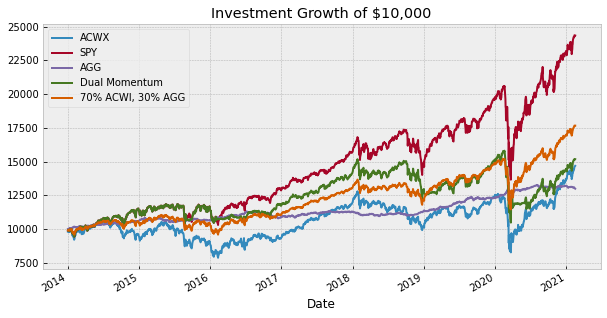

In [6]:
((ports_ret["2014-01-01":] + 1).cumprod() * 10000).plot(figsize=(10, 5), title="Investment Growth of $10,000")


In [7]:
oos_ports_ret = ports_ret["2014-01-01":]
back_test_results = pd.DataFrame()
back_test_results["Return"] = annualized_returns(oos_ports_ret, 252) * 100
back_test_results["Volatility"] = oos_ports_ret.std() * 252 ** 0.5 * 100
back_test_results["Sharpe Ratio"] = sharpe_ratio(oos_ports_ret)
back_test_results["Maximum Drawdowns"] = get_drawdowns(oos_ports_ret).min() * 100
back_test_results = back_test_results.round(2)

In [8]:
back_test_results.to_clipboard()

In [9]:
rolling_sharpe = pd.DataFrame()
for column in ports_ret.columns:
    rolling_sharpe[column] = ports_ret[column].rolling(252 * 3).apply(lambda sub_sample: sharpe_ratio(sub_sample))

<AxesSubplot:title={'center':'Rolling 3-year Sharpe Ratio'}, xlabel='Date'>

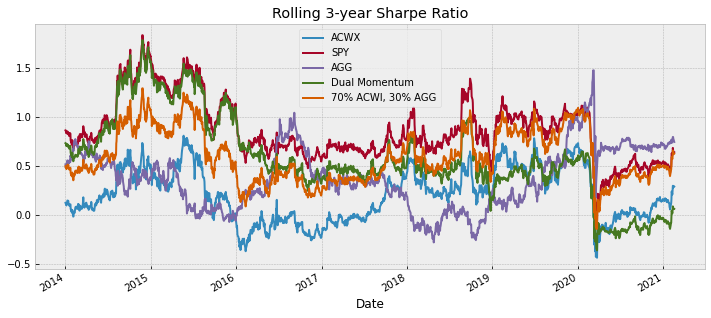

In [10]:
rolling_sharpe["2014-01-01":].plot(figsize=(12,5), title="Rolling 3-year Sharpe Ratio")

<AxesSubplot:title={'center':'Dual Momentum: Positions over time'}, xlabel='Date'>

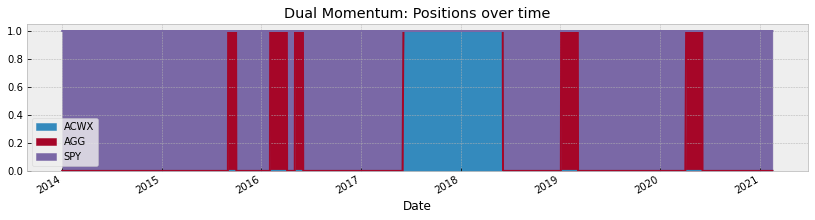

In [11]:
positions["2014-01-01":].plot.area(figsize=(14,3), title="Dual Momentum: Positions over time")


In [12]:
positions["2018-01-01":].to_clipboard()

<AxesSubplot:xlabel='Date'>

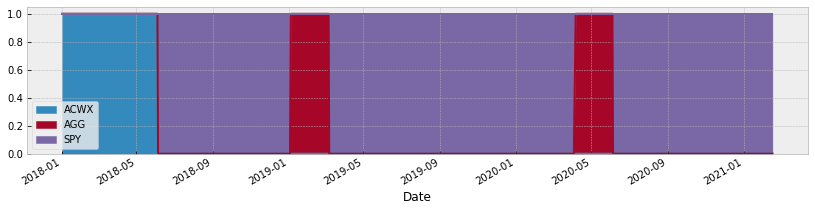

In [13]:
positions["2018-01-01":].plot.area(figsize=(14,3))

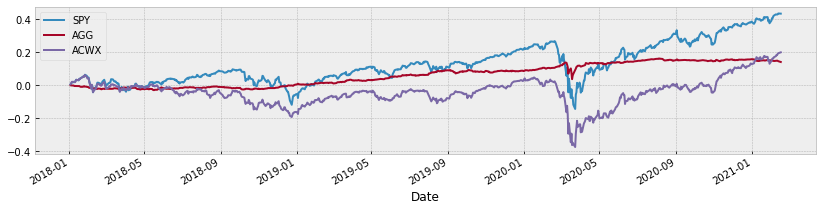

In [14]:
sub_df = prices[["SPY", "AGG", "ACWX"]]["2018-01-01":]
np.log(sub_df / sub_df.shift()).cumsum().plot(figsize=(14,3))
plt.legend()

In [15]:
# Lookback parameter robustness
GEM = pd.DataFrame()
for lookback in range(1, 13):
    positions, ports_ret = dual_mom(lookback=lookback*21, rebalancing_frequency=21*1)
    GEM[f"GEM {lookback} Mo"] = ports_ret["Dual Momentum"]
GEM.dropna(inplace=True)

In [16]:
GEM["1/N"] = ports_ret.drop("Dual Momentum", axis=1).mean(axis=1)
GEM = GEM["2014-01-01":]

<AxesSubplot:title={'center':'GEM Sharpe Ratio (Return / Standard Deviation)'}>

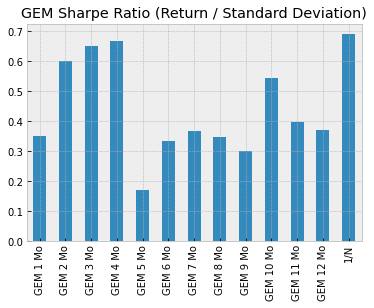

In [17]:
sharpe_ratio(GEM.dropna(), rf=0).plot(kind="bar", title="GEM Sharpe Ratio (Return / Standard Deviation)")

<AxesSubplot:title={'center':'GEM Max Drawdowns (Robustness check)'}>

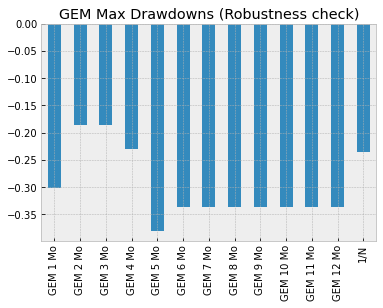

In [18]:
get_drawdowns(GEM).min().plot(kind="bar", title="GEM Max Drawdowns (Robustness check)")

Text(0, 0.5, '% return')

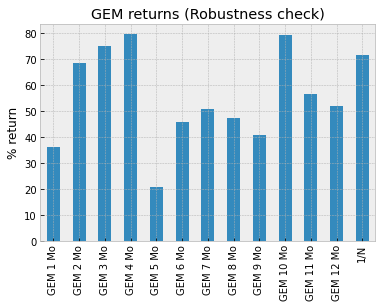

In [19]:
(((GEM + 1).prod() - 1) * 100).plot(kind="bar", title="GEM returns (Robustness check)")
plt.ylabel("% return")